# Dataset analysis

Plots and stats for the yeast dataset, after removing outliers, before sequence clustering. Most of the intricate analysis has already been done in the outliers notebook, this is just a few additional plots.

## Imports

In [1]:
from subpred.transporter_dataset import create_dataset
from subpred.compositions import calculate_aac, calculate_paac
from subpred.plots import (
    labeled_clustermap,
    get_clusters,
    corr_heatmap,
    pca_plot_2d,
    pca_plot_3d,
    feature_importance_plot,
)
from subpred.util import get_feature_score, perform_pca
from subpred.pssm import calculate_pssms_notebook
import seaborn as sns
import matplotlib.pyplot as plt

## Creating the dataset

In [2]:
df = create_dataset(
    keywords_substrate_filter = ["Amino-acid transport","Sugar transport"],
    keywords_component_filter = ["Transmembrane"],
    keywords_transport_filter = ["Transport"],
    input_file = "../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate = "integrate",
    verbose = True,
    tax_ids_filter = [559292],
    output_log = "../logs/yeast_amino_sugar_dataset.log",
)

In [3]:
df.head()

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
P0CD99,Sugar transport,Cell membrane;Membrane;Transmembrane,Transport,MPH2 YDL247W,Alpha-glucosides permease MPH2 (Maltose transp...,NaN,0.0,559292,MKNLSFLINRRKENTSDSNVYPGKAKSHEPSWIEMDDQTKKDGLDI...
Q08986,Amino-acid transport,Endoplasmic reticulum;Membrane;Transmembrane,Transport,SAM3 YPL274W,S-adenosylmethionine permease SAM3 (S-adenosyl...,2.A.3.10.15,2.A,559292,MDILKRGNESDKFTKIETESTTIPNDSDRSGSLIRRMKDSFKQSNL...
P38967,Amino-acid transport,Membrane;Transmembrane,Transport,TAT2 LTG3 SAB2 SCM2 TAP2 YOL020W,Tryptophan permease (Tryptophan amino acid tra...,2.A.3.10.8,2.A,559292,MTEDFISSVKRSNEELKERKSNFGFVEYKSKQLTSSSSHNSNSSHH...
P39003,Sugar transport,Membrane;Transmembrane,Transport,HXT6 YDR343C D9651.12,High-affinity hexose transporter HXT6,NaN,0.0,559292,MSQDAAIAEQTPVEHLSAVDSASHSVLSTPSNKAERDEIKAYGEGE...
P38085,Amino-acid transport,Membrane;Transmembrane,Transport,TAT1 TAP1 VAP1 YBR069C YBR0710,Valine/tyrosine/tryptophan amino-acid permease...,2.A.3.10.9,2.A,559292,MDDSVSFIAKEASPAQYSHSLHERTHSEKQKRDFTITEKQDEVSGQ...


### Stats

Imbalanced dataset, the number of sugar transporters might be a bit low, as it was in human

In [4]:
df.keywords_transport.value_counts()

Amino-acid transport    36
Sugar transport         28
Name: keywords_transport, dtype: int64

In [5]:
df.keywords_location.value_counts()

Membrane;Transmembrane                                        44
Cell membrane;Membrane;Transmembrane                           9
Endoplasmic reticulum;Membrane;Transmembrane                   6
Membrane;Mitochondrion;Transmembrane                           3
Cell membrane;Endoplasmic reticulum;Membrane;Transmembrane     2
Name: keywords_location, dtype: int64

Are there any sequence clusters that correspond to the locations?

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

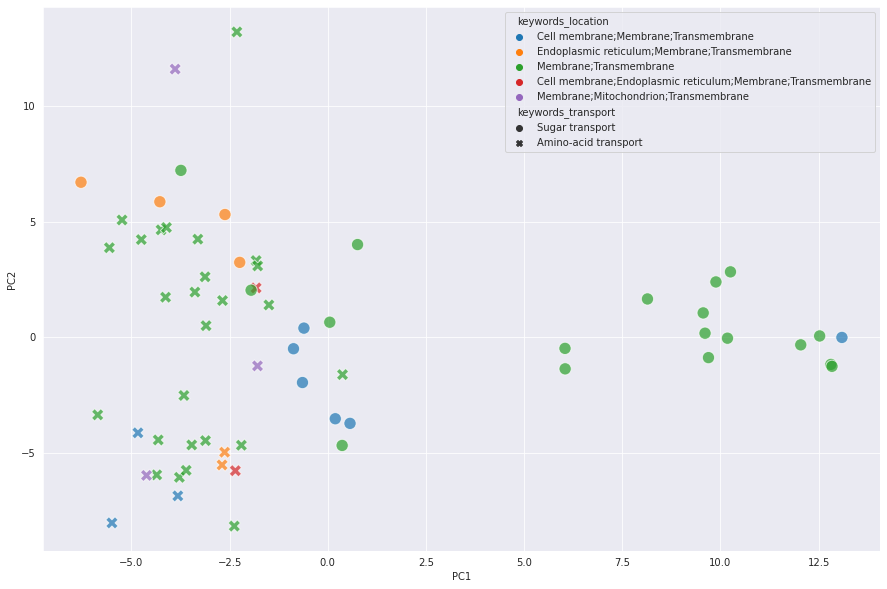

In [6]:
df_paac = calculate_paac(df.sequence)

pca_plot_2d(df_paac, df.keywords_location, df.keywords_transport, figsize=(15,10), marker_size=150, marker_opacity=0.7)

No, it does not look like there are. There is a cluster on the right, which we already found in Notebook 1.

The cluster on the right is still mainly made up of Hexose transporters, and also Glucose transporters from the same HXL family:

In [7]:
pca_paac = perform_pca(df_paac, df.keywords_transport)

df.loc[pca_paac[pca_paac.PC1 > 2.5].index].protein_names

Uniprot
P39003                High-affinity hexose transporter HXT6
P23585               High-affinity glucose transporter HXT2
P39004                High-affinity hexose transporter HXT7
P32465                Low-affinity glucose transporter HXT1
P40886                              Hexose transporter HXT8
P13181           Galactose transporter (Galactose permease)
P32467    Low-affinity glucose transporter HXT4 (Low-aff...
P40885                              Hexose transporter HXT9
P54854                             Hexose transporter HXT15
P38695                    Probable glucose transporter HXT5
P43581                             Hexose transporter HXT10
P32466                Low-affinity glucose transporter HXT3
P54862    Hexose transporter HXT11 (Low-affinity glucose...
P39924                             Hexose transporter HXT13
Name: protein_names, dtype: object

They have relatively high correlations:

<AxesSubplot:xlabel='Uniprot', ylabel='Uniprot'>

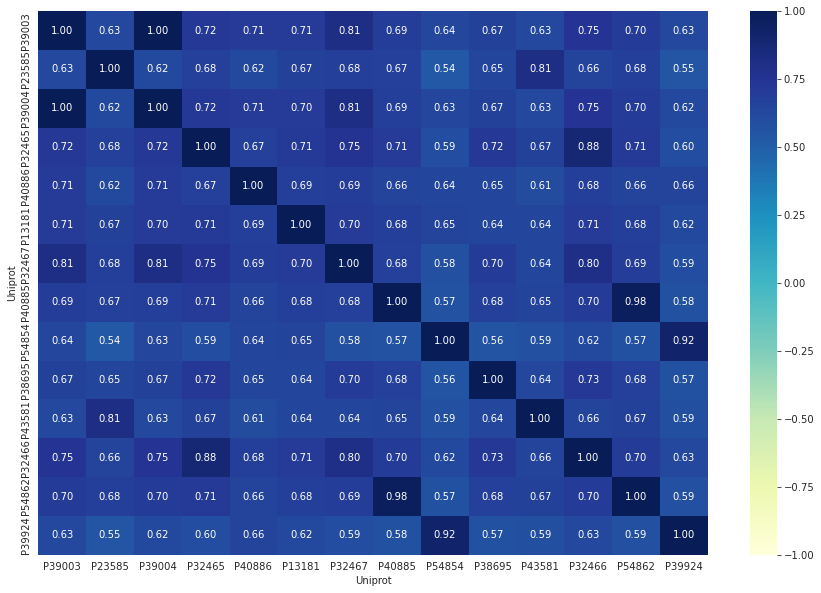

In [8]:
corr_heatmap(calculate_paac(df.loc[pca_paac[pca_paac.PC1 > 2.5].index].sequence).T)

Which sugars are in the dataset, besides hexose and glucose?

In [9]:
sugars = df.protein_names.apply(
    lambda x: [y.replace("(", "").lower() for y in x.split() if y.endswith("ose")]
).apply(lambda x: x[0] if x else "polysaccaride or amino acid")
sugars.value_counts()

polysaccaride or amino acid    41
hexose                          9
glucose                         7
maltose                         4
galactose                       1
gdp-mannose                     1
udp-galactose                   1
Name: protein_names, dtype: int64

Mainly hexose and glucose. Maltose is made up of two glucoses, Galactose and Mannose are Hexoses as well.

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

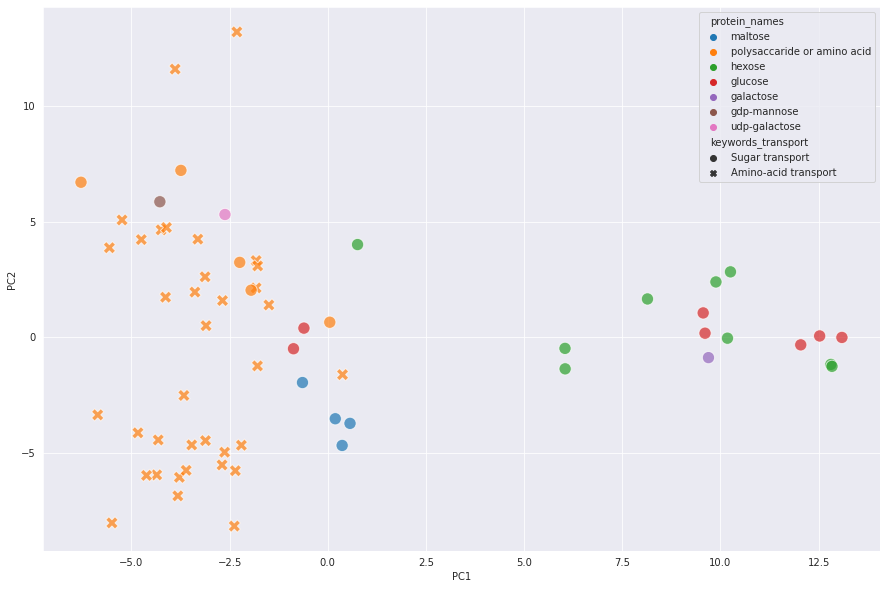

In [10]:
pca_plot_2d(
    df_paac,
    sugars,
    df.keywords_transport,
    figsize=(15, 10),
    marker_size=150,
    marker_opacity=0.7,
)

If we removed polysaccharides (orange) and the nucleotide-sugars (brown, rose), we could actually use these two principal component with a linear SVM, and only get one misclassified amino-acid transporter. Which one is that?

In [11]:
df.loc[
    pca_paac.loc[
        df.keywords_transport.str.startswith("Amino") & (pca_paac.PC1 > 0)
    ].index
]

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
P50276,Amino-acid transport,Membrane;Transmembrane,Transport,MUP1 YGR055W,High-affinity methionine permease,2.A.3.8.4,2.A,559292,MSEGRTFLSQLNVFNKENYQFSSSTTKKEVSNSTVDADNGASDFEA...


Lets create a dataframe of monosaccharides and amino acids:

In [12]:
df_mono = df[
    (df.keywords_transport.str.startswith("Sugar")
    & (df.protein_names.str.match(".*[A-Za-z]+ose.*"))
    & ~(df.protein_names.str.match("(UDP|GDP)"))) | df.keywords_transport.str.startswith("Amino")
]
df_mono.keywords_transport.value_counts() 

Amino-acid transport    36
Sugar transport         21
Name: keywords_transport, dtype: int64

Amino acid transporters seem to be divided into vacuolar and non-vacuolar transporters. They form two clusters:

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

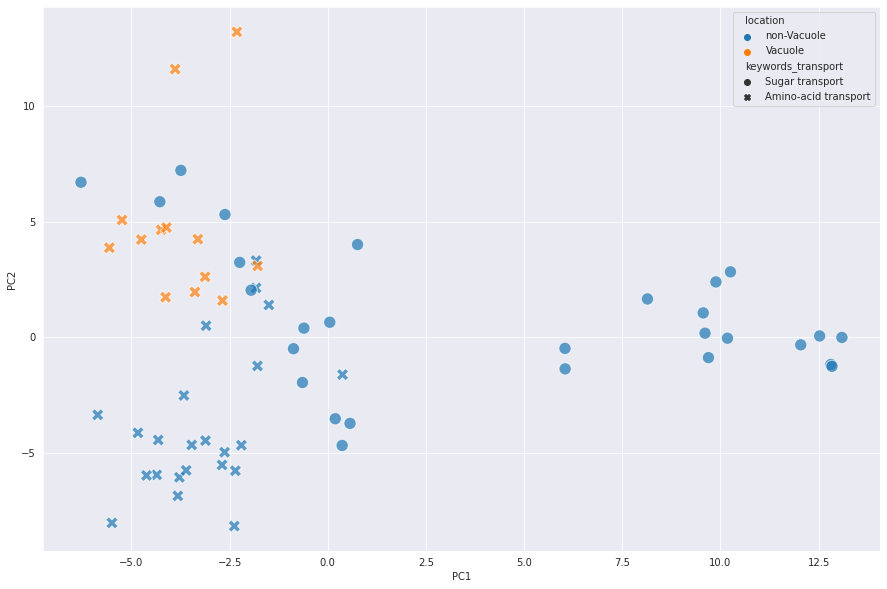

In [13]:
vacuolar = df.protein_names.transform(
    lambda x: "Vacuole" if "vacu" in x.lower() else "non-Vacuole"
).rename("location")

pca_plot_2d(
    df_paac,
    vacuolar,
    df.keywords_transport,
    figsize=(15, 10),
    marker_size=150,
    marker_opacity=0.7,
)


In conclusion, we might be able to improve the dataset for training by either removing Vacuolar amino acid transporters, or non-monosaccharide sugar transporters, since they form their own cluster on the top left.

In [14]:
df.keywords_transport_related.value_counts()

Transport            63
Symport;Transport     1
Name: keywords_transport_related, dtype: int64

There is one symporter, called MAL11:

In [15]:
df[df.keywords_transport_related.str.contains("Symport")]

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
P53048,Sugar transport,Cell membrane;Membrane;Transmembrane,Symport;Transport,MAL11 AGT1 MAL1T MTP1 YGR289C,General alpha-glucoside permease (Maltose perm...,2.A.1.1.11,2.A,559292,MKNIISLVSKKKAASKNEDKNISESSRDIVNQQEVFNTEDFEEGKK...


There is another MAL transporter in the dataset, but only a total of two:

In [16]:
df[df.gene_names.str.contains("MAL")]

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
P38156,Sugar transport,Membrane;Transmembrane,Transport,MAL31 MAL3T YBR298C YBR2116,Maltose permease MAL31 (Maltose transport prot...,NaN,0.0,559292,MKGLSSLINRKKDRNDSHLDEIENGVNATEFNSIEMEEQGKKSDFD...
P53048,Sugar transport,Cell membrane;Membrane;Transmembrane,Symport;Transport,MAL11 AGT1 MAL1T MTP1 YGR289C,General alpha-glucoside permease (Maltose perm...,2.A.1.1.11,2.A,559292,MKNIISLVSKKKAASKNEDKNISESSRDIVNQQEVFNTEDFEEGKK...


In [17]:
df_paac.T.corr().loc["P53048", "P38156"].round(3)

0.601

#### TCDB


In [18]:
df.tcdb_class.value_counts()

2.A    55
0.0     9
Name: tcdb_class, dtype: int64

The proteins without TCDB classification include the majority of the HXT transporters, and other maltose transporters.

In [19]:
df[df.tcdb_class.str.startswith("0")]

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
P0CD99,Sugar transport,Cell membrane;Membrane;Transmembrane,Transport,MPH2 YDL247W,Alpha-glucosides permease MPH2 (Maltose transp...,NaN,0.0,559292,MKNLSFLINRRKENTSDSNVYPGKAKSHEPSWIEMDDQTKKDGLDI...
P39003,Sugar transport,Membrane;Transmembrane,Transport,HXT6 YDR343C D9651.12,High-affinity hexose transporter HXT6,NaN,0.0,559292,MSQDAAIAEQTPVEHLSAVDSASHSVLSTPSNKAERDEIKAYGEGE...
P40886,Sugar transport,Membrane;Transmembrane,Transport,HXT8 YJL214W HRA569 J0232,Hexose transporter HXT8,NaN,0.0,559292,MTDRKTNLPEEPIFEEAEDDGCPSIENSSHLSVPTVEENKDFSEYN...
P38156,Sugar transport,Membrane;Transmembrane,Transport,MAL31 MAL3T YBR298C YBR2116,Maltose permease MAL31 (Maltose transport prot...,NaN,0.0,559292,MKGLSSLINRKKDRNDSHLDEIENGVNATEFNSIEMEEQGKKSDFD...
P40885,Sugar transport,Membrane;Transmembrane,Transport,HXT9 YJL219W HRC567 J0222,Hexose transporter HXT9,NaN,0.0,559292,MSGVNNTSANDLSTTESNSNSVANAPSVKTEHNDSKNSLNLDATEP...
P0CE00,Sugar transport,Cell membrane;Membrane;Transmembrane,Transport,MPH3 YJR160C J2400,Alpha-glucosides permease MPH3 (Maltose transp...,NaN,0.0,559292,MKNLSFLINRRKENTSDSNVYPGKAKSHEPSWIEMDDQTKKDGLDI...
P38695,Sugar transport,Membrane;Transmembrane,Transport,HXT5 YHR096C,Probable glucose transporter HXT5,NaN,0.0,559292,MSELENAHQGPLEGSATVSTNSNSYNEKSGNSTAPGTAGYNDNLAQ...
P32466,Sugar transport,Membrane;Transmembrane,Transport,HXT3 YDR345C D9651.14,Low-affinity glucose transporter HXT3,NaN,0.0,559292,MNSTPDLISPQKSSENSNADLPSNSSQVMNMPEEKGVQDDFQAEAD...
P25594,Amino-acid transport,Membrane;Transmembrane,Transport,VBA3 YCL069W YCL69W,Vacuolar basic amino acid transporter 3,NaN,0.0,559292,MNMLIVGRVVASVGGSGLQTLCFVIGCTMVGERSRPLVISILSCAF...


According to Uniprot, there are two distinct transport systems: Low-affinity and high-affinity. Is there a difference in terms of sequence?

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

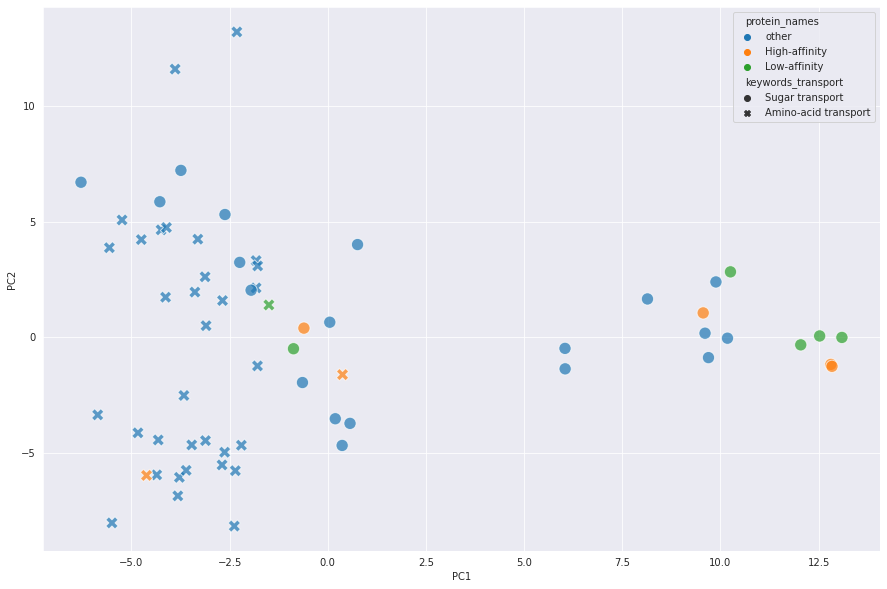

In [20]:
pca_plot_2d(
    df_paac,
    df.protein_names.transform(
        lambda x: "High-affinity"
        if "high-affinity" in x.lower()
        else ("Low-affinity" if "low-affinity" in x.lower() else "other")
    ),
    df.keywords_transport,
    figsize=(15, 10),
    marker_size=150,
    marker_opacity=0.7,
)


It does not look like there is a difference.

## Feature generation

In [21]:
labels = df.keywords_transport.rename("label").copy()
df_aac = calculate_aac(sequences=df.sequence)
df_paac = calculate_paac(sequences=df.sequence)
df_pssm = calculate_pssms_notebook(sequences=df.sequence)

Hierarchical clustering can't quite distinguish all transporters into their categories, although there are some subcluster that only transport sugar or amino acid.

({'Amino-acid transport': 'cyan', 'Sugar transport': 'magenta'},
 <seaborn.matrix.ClusterGrid at 0x7fdaffbf52b0>)

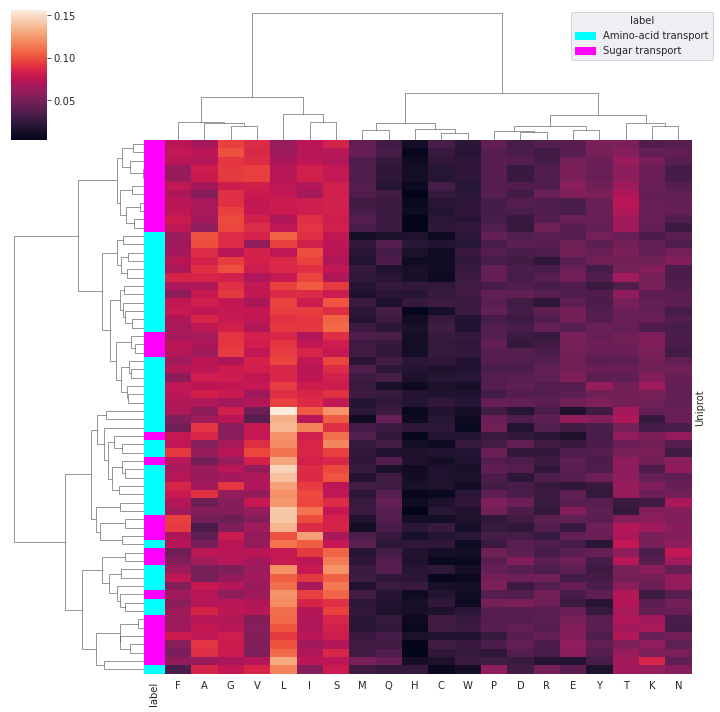

In [22]:
labeled_clustermap(df_aac, labels, xlabels="auto")

Where are the sugars on this cluster?

({'galactose': 'cyan',
  'gdp-mannose': 'magenta',
  'glucose': 'yellow',
  'hexose': 'green',
  'maltose': 'orange',
  'polysaccaride or amino acid': 'red'},
 <seaborn.matrix.ClusterGrid at 0x7fdaff5524c0>)

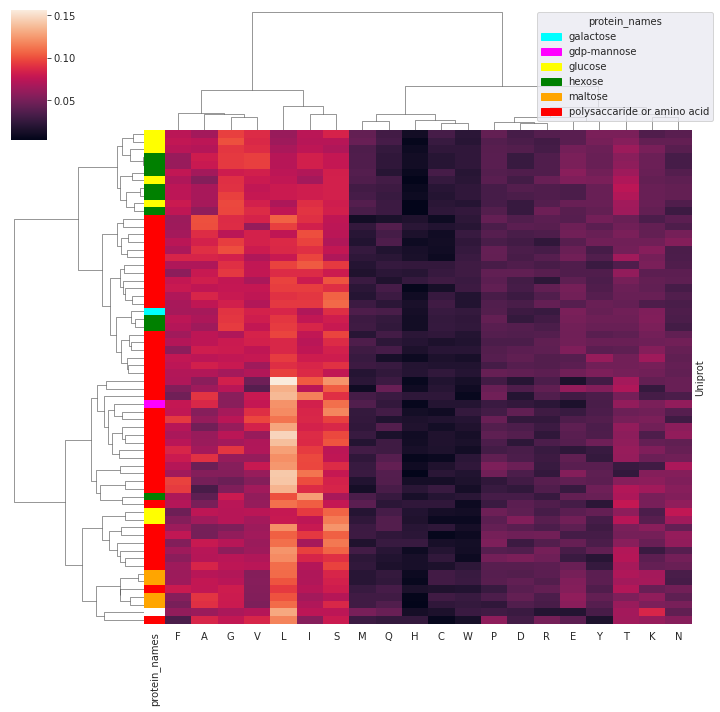

In [23]:
labeled_clustermap(df_aac, sugars, xlabels="auto")

The pattern seems to emerge here too! There are two clusters, one with the vacuolar amino-acid transporters and the non-monosaccharide sugar transporters, and one with clearly distinguishable sugar and amino acid transporters.

({'Vacuole': 'cyan', 'non-Vacuole': 'magenta'},
 <seaborn.matrix.ClusterGrid at 0x7fdafd4a9d60>)

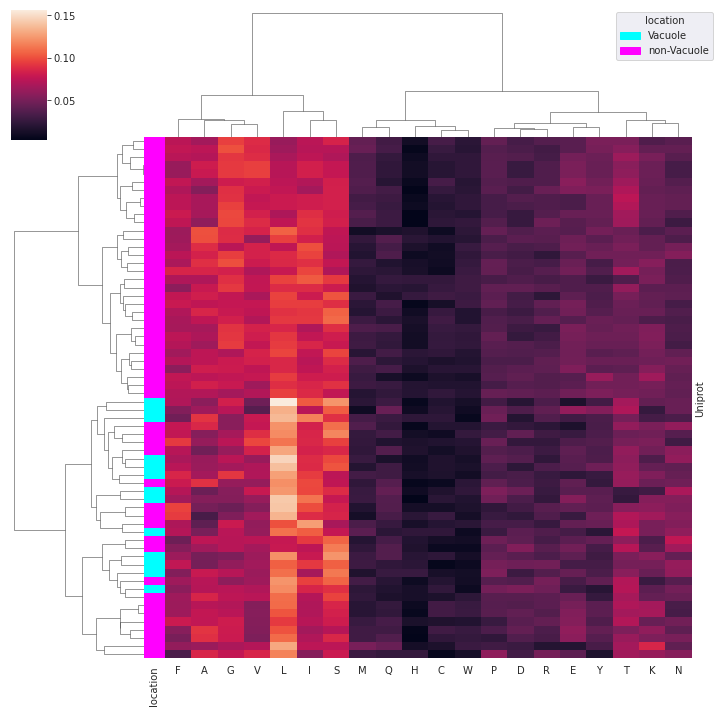

In [24]:
labeled_clustermap(df_aac, vacuolar, xlabels="auto")

### PAAC plot

Some of the sub-clusters only contain one substrate class

({'Amino-acid transport': 'cyan', 'Sugar transport': 'magenta'},
 <seaborn.matrix.ClusterGrid at 0x7fdaff9240d0>)

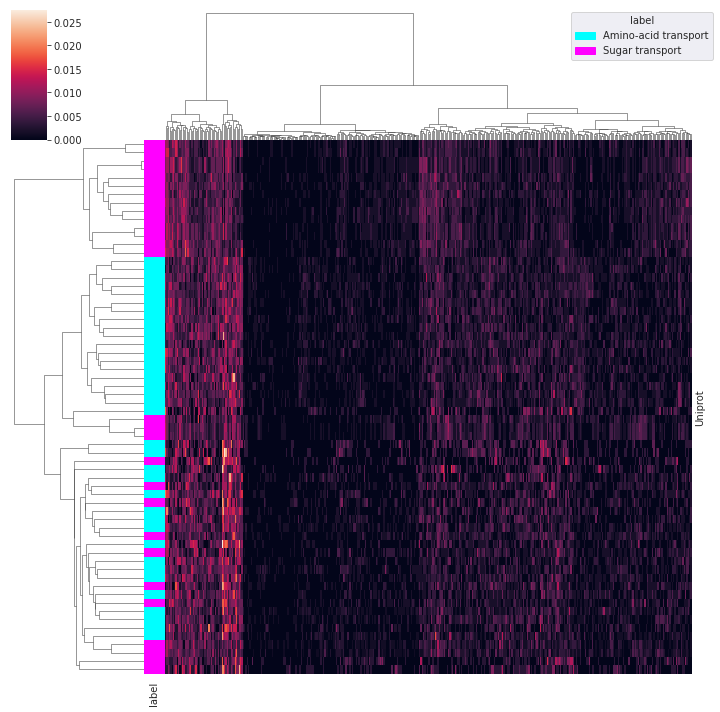

In [25]:
labeled_clustermap(df_paac, labels)

In [26]:
cluster0, cluster1 = get_clusters(df_paac.T, n_clusters=2)

print(len(cluster0))
print(len(cluster1))

from collections import Counter

counter = Counter()
for dipeptide in cluster1:
    counter[dipeptide[0]] += 1
    counter[dipeptide[1]] += 1

counter.most_common()

341
59


[('L', 18),
 ('S', 17),
 ('I', 16),
 ('G', 15),
 ('A', 14),
 ('F', 14),
 ('V', 14),
 ('T', 7),
 ('P', 2),
 ('K', 1)]

In [27]:
get_feature_score(df_paac, labels, remove_zero_variance=True).sort_values(
    "Normalized score", ascending=False
).reset_index(drop=True).head(20)

,Feature,Normalized score,Measure
0,GM,0.030821,Feature importance (f_classif)
1,NP,0.020864,Feature importance (f_classif)
2,YQ,0.018541,Feature importance (f_classif)
3,PW,0.016877,Feature importance (f_classif)
4,WA,0.014719,Feature importance (f_classif)
5,FW,0.014375,Feature importance (f_classif)
6,YF,0.014048,Feature importance (f_classif)
7,CF,0.013745,Feature importance (f_classif)
8,PG,0.013726,Feature importance (f_classif)
9,RT,0.012981,Feature importance (f_classif)


The most important feature with a large margin seems to be Glycine-Methionine, followed by Aspartagine-Proline. Asp can influence selectivity, while GM could be more related to structure. Some of the substrates in the dataset are much larger than others, like polysaccharides for example.

## Feature plots



#### Correlation

There do not seem to be any features that show a high correlation across all classes:

<AxesSubplot:>

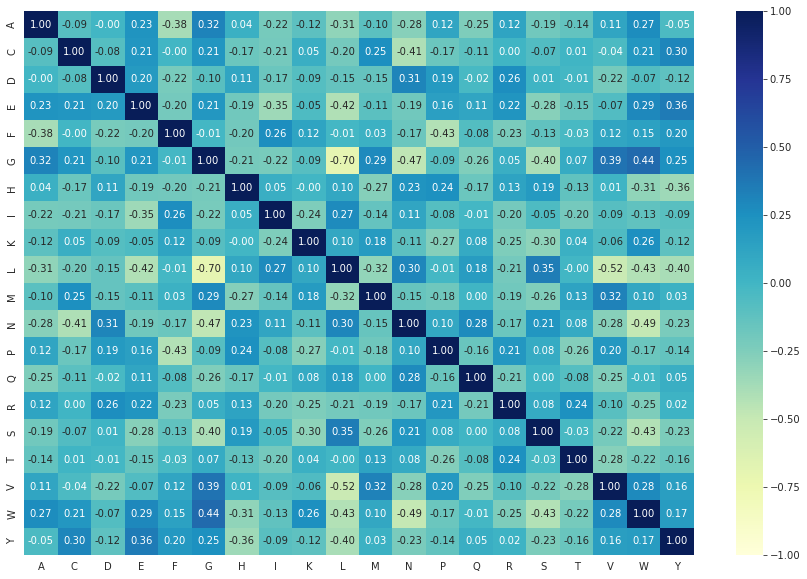

In [28]:
corr_heatmap(df_aac)

<AxesSubplot:>

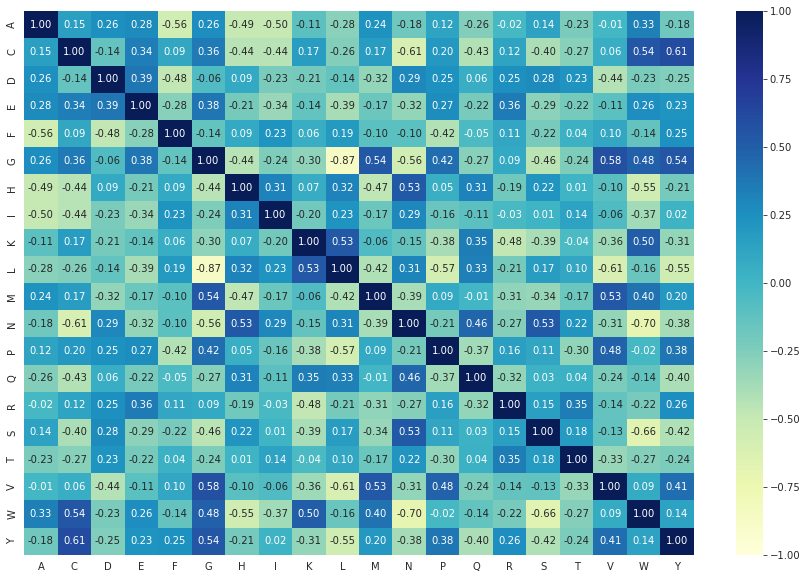

In [29]:
corr_heatmap(df_aac.loc[df[df.keywords_transport == "Sugar transport"].index])

<AxesSubplot:>

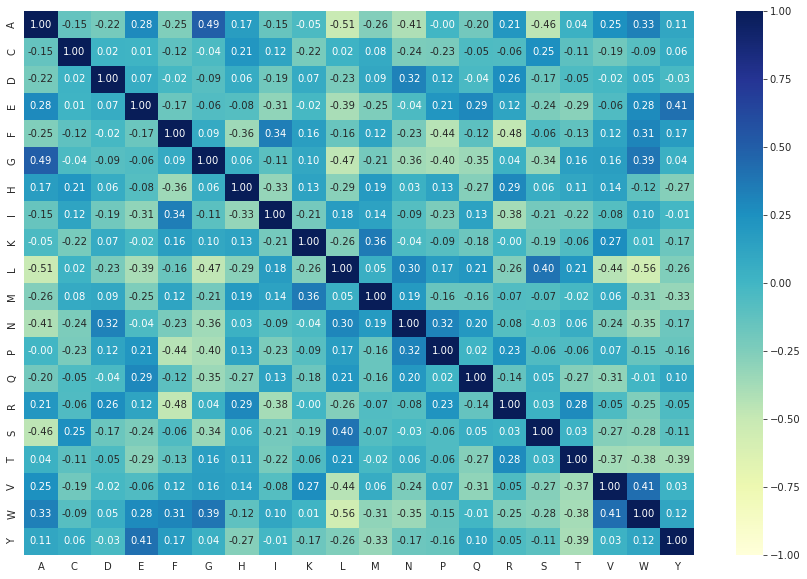

In [30]:
corr_heatmap(df_aac.loc[df[df.keywords_transport == "Amino-acid transport"].index])

#### Distribution

In [31]:
df_aac_long = (
    df_aac.stack(level=None)
    .reset_index()
    .rename(columns={"level_1": "Amino Acid", 0: "Frequency"})
    .merge(df.keywords_transport, left_on="Uniprot", right_index=True)
)
df_aac_long.head()

,Uniprot,Amino Acid,Frequency,keywords_transport
0,P0CD99,A,0.072250,Sugar transport
1,P0CD99,C,0.029557,Sugar transport
2,P0CD99,D,0.036125,Sugar transport
3,P0CD99,E,0.049261,Sugar transport
4,P0CD99,F,0.062397,Sugar transport


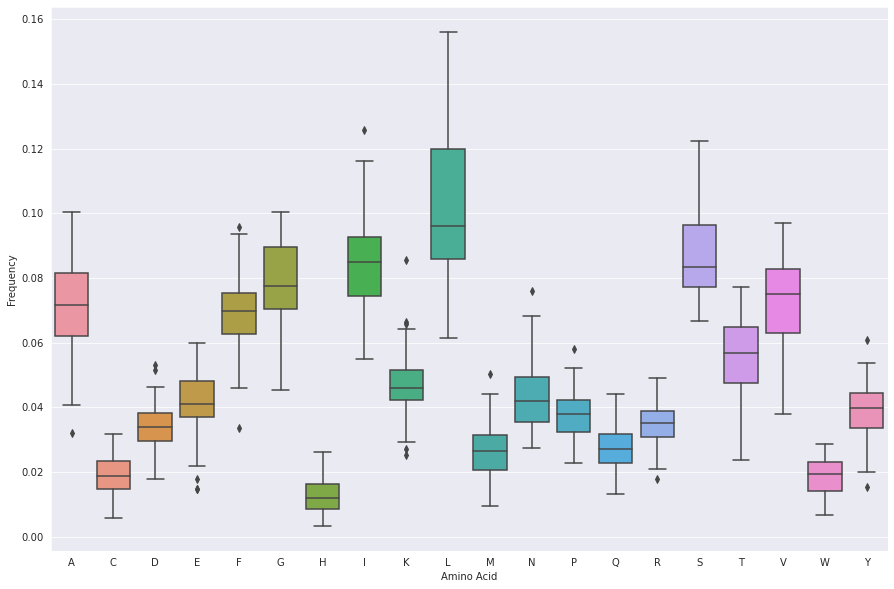

In [32]:
plt.figure(figsize=(15,10))
g = sns.boxplot(
    data=df_aac_long,
    x="Amino Acid",
    y="Frequency",
    # hue="keywords_transport"
)

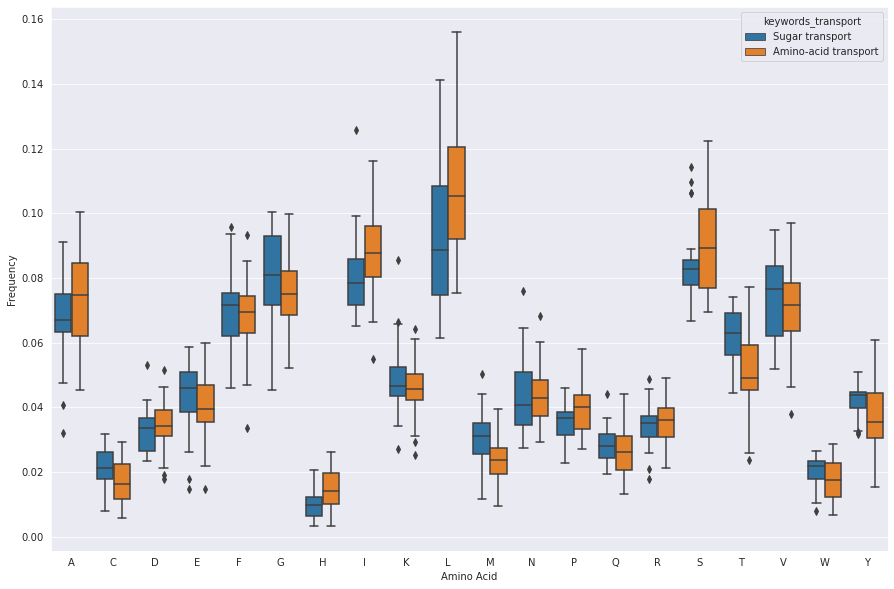

In [33]:
plt.figure(figsize=(15,10))
g = sns.boxplot(
    data=df_aac_long,
    x="Amino Acid",
    y="Frequency",
    hue="keywords_transport"
)

At a first glance, the biggest difference manifests in Histidine and Methionine, although a combination of multiple features is probably needed.

According to shapiro-wilk, the features mostly follow normal dist. Sample sizes for the dipeptides in PAAC is too low for a distribution test.

<AxesSubplot:>

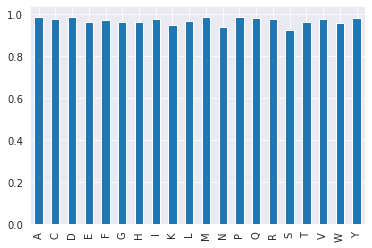

In [34]:
from scipy.stats import shapiro

df_aac.apply(shapiro).loc[0].plot.bar()

### PSSM plots


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

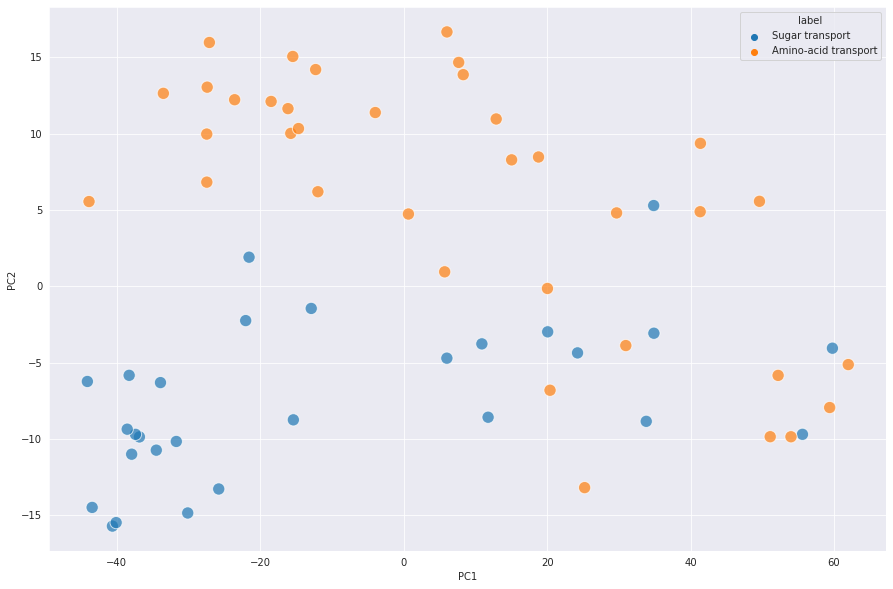

In [35]:
pca_plot_2d(df_pssm, labels, figsize=(15,10), marker_size=150, marker_opacity=0.7)

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

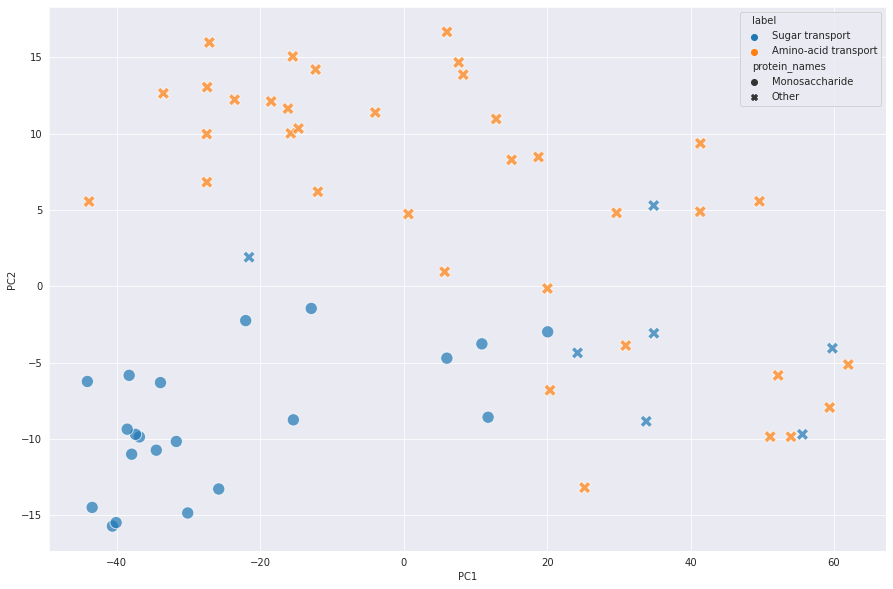

In [52]:
import numpy as np
import pandas as pd

sugars2 = sugars.transform(lambda x: "Monosaccharide" if x in {"maltose", "hexose", "glucose", "galactose"} else "Other" )
pca_plot_2d(df_pssm, labels, sugars2, figsize=(15,10), marker_size=150, marker_opacity=0.7)

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

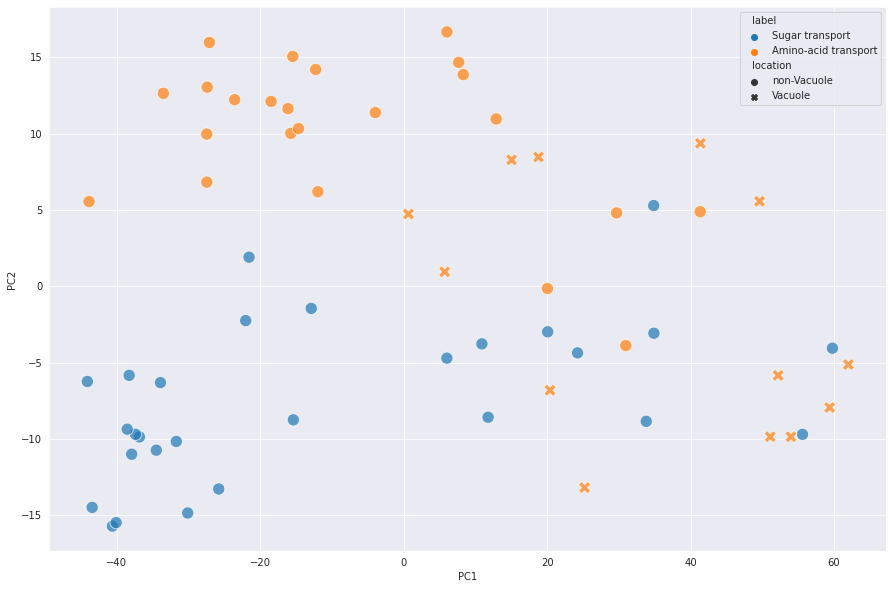

In [51]:
pca_plot_2d(df_pssm, labels,vacuolar, figsize=(15,10), marker_size=150, marker_opacity=0.7)

For the PSSM feature, there is also a cluster of monosaccharides, a cluster of non-vacuolar AA transporters, and a mixed cluster on the right. What would it look like without that cluster on the right?

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

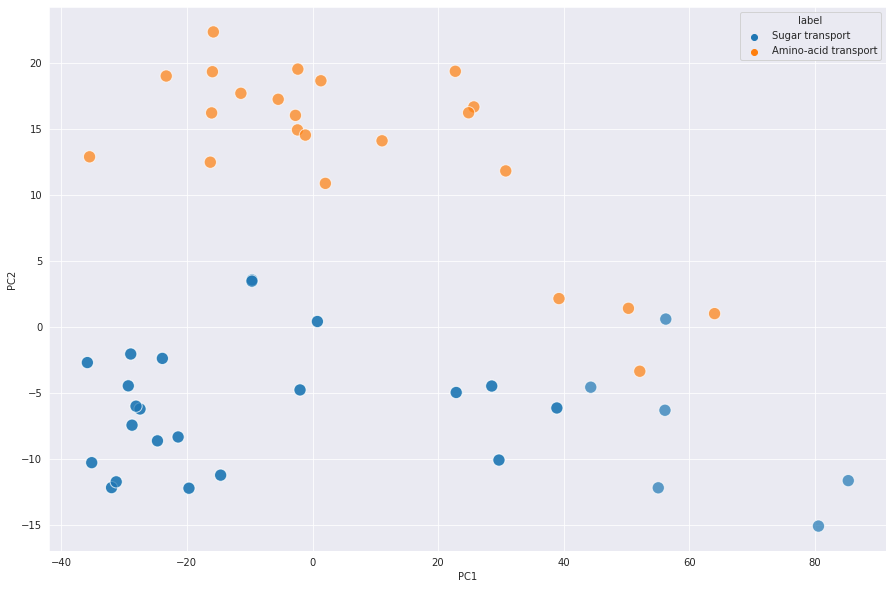

In [48]:
other_proteins = vacuolar[vacuolar == "non-Vacuole"].index.tolist() + sugars2[sugars2 == "Monosaccharide"].index.tolist()

pca_plot_2d(df_pssm.loc[other_proteins], labels[other_proteins], figsize=(15,10), marker_size=150, marker_opacity=0.7)

Removing both vacuolar and polysaccharide/nucleotide-sugar transporters from the dataset could improve the fit of teh PSSM on the first two PCs, although this would exclude a large number of samples. If the performance is good enough, we will keep them in the dataset. 

({'Amino-acid transport': 'cyan', 'Sugar transport': 'magenta'},
 <seaborn.matrix.ClusterGrid at 0x7feb08ff4a60>)

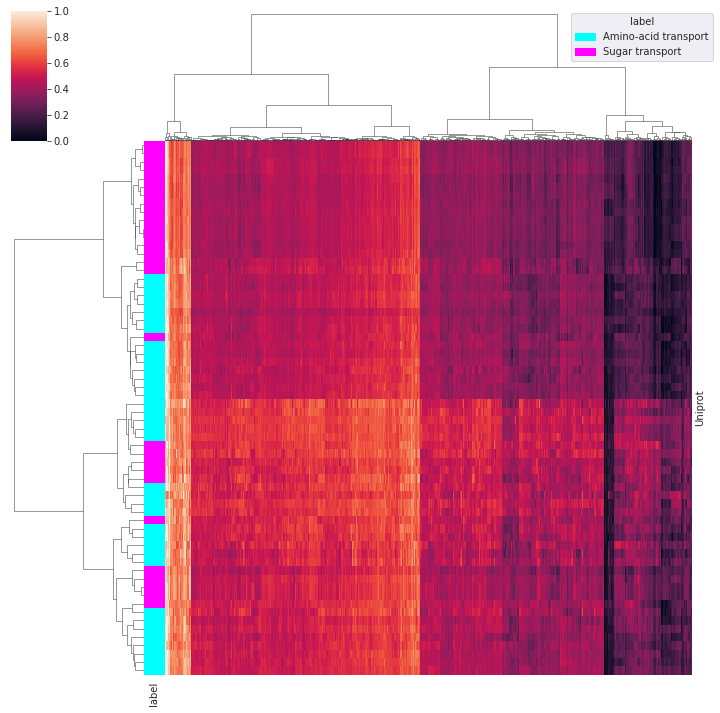

In [99]:
labeled_clustermap(df_pssm, labels)

## F score Plot

Histidine seems to be important, followed by Threonine and Methionine. These are all reactive amino acids that could determine specificity.

<AxesSubplot:xlabel='Feature', ylabel='Normalized score'>

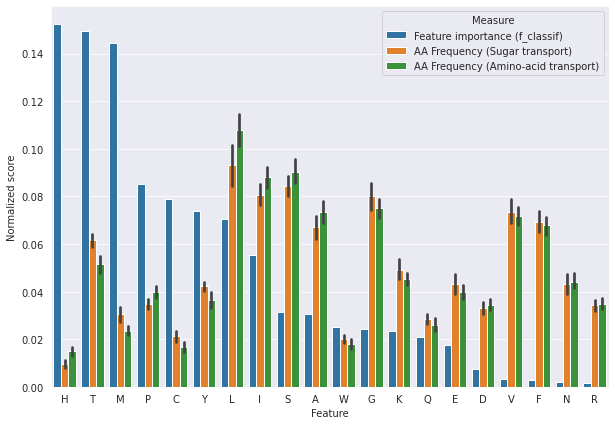

In [86]:
feature_importance_plot(df_aac, labels, method="f_classif")

<AxesSubplot:xlabel='Feature', ylabel='Normalized score'>

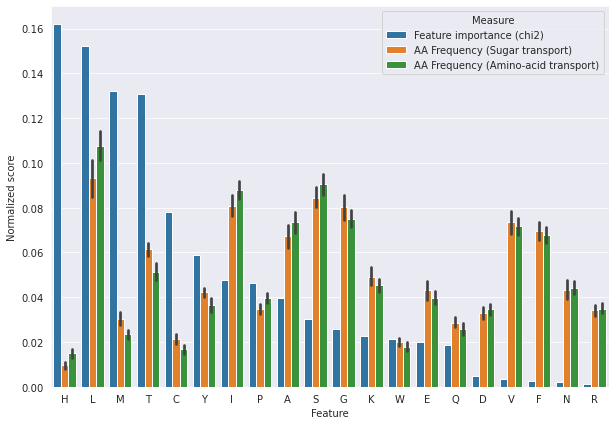

In [87]:
feature_importance_plot(df_aac, labels, method="chi2")